In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import csv
import pyproj
import pickle
import xarray as xr

In [2]:
# Upload Barents2.5 ataset to import full grid data 
dataset0 = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T00Z.nc")

X = dataset0['X']
Y = dataset0['Y']
lon = dataset0['lon']
lat = dataset0['lat']
model_proj4 = dataset0.projection_lambert.proj4

In [3]:
# Specify path with cumulative drift fields for specific par of images

barents_model_drift_path = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_24ens_cum_disp_14-16feb.csv"
algorithm_drift_path = "/home/jovyan/experiment_data/2022-2023_48h_experiment/drift_output/14_16_feb/barents_algorithm_disp_14-16feb.csv"

##### Import model data

In [4]:
with open(barents_model_drift_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)
    cum_dx_b = displacements[:, [2]] 
    cum_dy_b = displacements[:, [3]]

In [5]:
# Reshape 1d csv data according to the grid

# Set full model grid for model data
full_model_shape = lon.shape

cum_dx_b = np.reshape(cum_dx_b, full_model_shape)
cum_dy_b = np.reshape(cum_dy_b, full_model_shape)
cum_dx_b[np.isinf(cum_dx_b)] = np.nan
cum_dy_b[np.isinf(cum_dy_b)] = np.nan

##### Calculating velocities

In [ ]:
'''
#Calculate velocities if needed
# Divide values in the first list by 2272
cum_dx_b[0] /= (3600-time_diff_start)
cum_dy_b[0] /= (3600-time_diff_start)

# Divide values in the middle lists by 3600
for i in range(1, len(cum_dx_b)-1):
    cum_dx_b[i] /= ((3600-time_diff_start) + i*3600)
    cum_dy_b[i] /= ((3600-time_diff_start) + i*3600)

# Divide values in the last list by 179
cum_dx_b[-1] /= total_time_diff
cum_dy_b[-1] /= total_time_diff

cum_dx_n[0] /= (3600-time_diff_start)
cum_dy_n[0] /= (3600-time_diff_start)

# Divide values in the middle lists by 3600
for i in range(1, len(cum_dx_b)-1):
    cum_dx_n[i] /= ((3600-time_diff_start) + i*3600)
    cum_dy_n[i] /= ((3600-time_diff_start) + i*3600)

# Divide values in the last list by 179
cum_dx_n[-1] /= total_time_diff
cum_dy_n[-1] /= total_time_diff
'''

##### Import algorithm drift data

In [6]:
with open(algorithm_drift_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)
    X_subset = displacements[:, [4]] 
    Y_subset = displacements[:, [5]]
    upm = displacements[:, [6]] 
    vpm = displacements[:, [7]]

In [7]:
# Reshape 1d csv data according to the grid

# Set subset grid for algorithm data
%store -r shape
feb1416_subset_shape = shape
print(feb1416_subset_shape)

upm = np.reshape(upm, feb1416_subset_shape)
vpm = np.reshape(vpm, feb1416_subset_shape)
upm[np.isinf(upm)] = np.nan
vpm[np.isinf(vpm)] = np.nan

(283, 219)


In [8]:
%store -r shape
feb1416_subset_shape = shape
print(feb1416_subset_shape)
X_subset = np.reshape(X_subset, feb1416_subset_shape)
Y_subset = np.reshape(Y_subset, feb1416_subset_shape)

In [9]:
# Preparing masks

# GPI with h < some value
%store -r gpi_1416_02

%store -r min_row
%store -r max_row
%store -r min_col
%store -r max_col

In [10]:
# Extract model data within the SAR subset
cum_dx_b_subset = cum_dx_b[min_row:max_row+1, min_col:max_col+1]
cum_dy_b_subset = cum_dy_b[min_row:max_row+1, min_col:max_col+1]

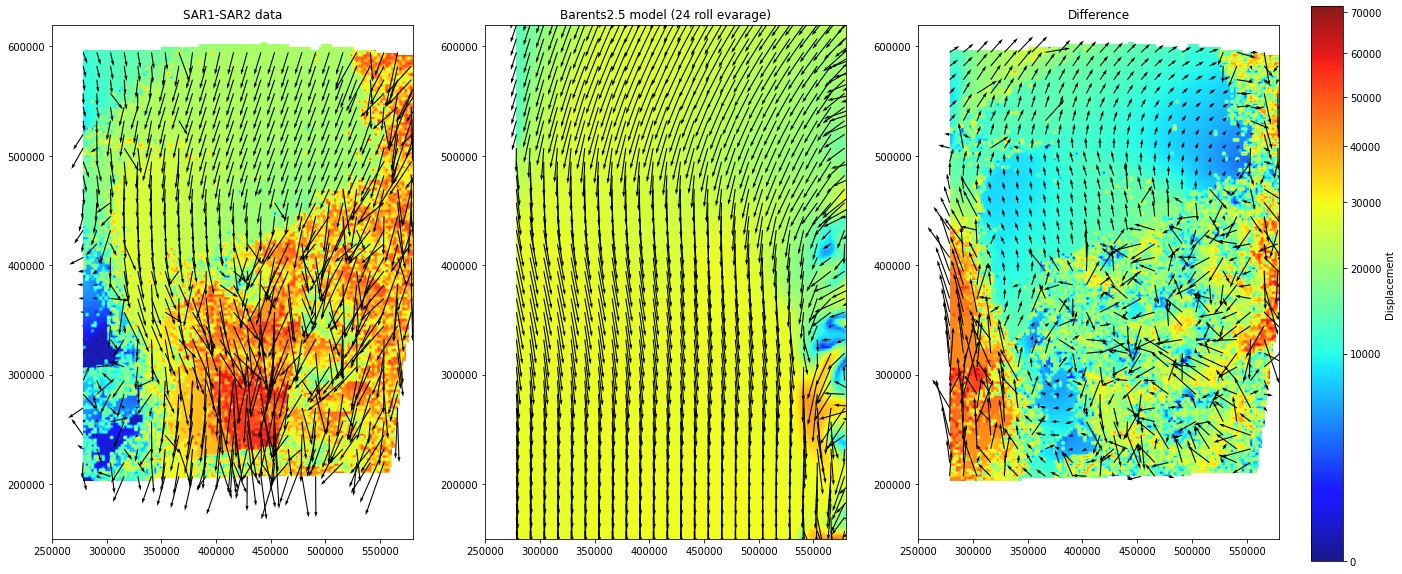

In [54]:
#Integrated drift filtered with gpi
from matplotlib.colors import PowerNorm
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))

disp_dif_x = upm - cum_dx_b_subset
disp_dif_y = vpm - cum_dy_b_subset
disp_dif = np.sqrt(( disp_dif_x**2+ disp_dif_y**2))

masked_disp_dif = np.full_like(disp_dif, np.nan)
masked_disp_dif[gpi_1416_02] = disp_dif[gpi_1416_02]

step = 5

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
quiver1 = ax1.quiver(X_subset[::step,::step], Y_subset[::step,::step], upm[::step,::step], vpm[::step,::step], 
                    angles='xy', scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image1 = ax1.imshow(disp_alg, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax1.set_xlim([0.25e6, 0.58e6]) 
ax1.set_ylim([0.15e6, 0.62e6])

ax1.set_aspect('equal')

quiver2 = ax2.quiver(X_subset[::step,::step], Y_subset[::step,::step], cum_dx_b_subset[::step,::step],cum_dy_b_subset[::step,::step],
                     angles='xy',scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image2 = ax2.imshow(disp_model_b, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax2.set_xlim([0.25e6, 0.58e6]) 
ax2.set_ylim([0.15e6, 0.62e6])
  
ax2.set_aspect('equal')

# Choose one of three ways to show difference:
# 0) Difference vectors
#quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
#                        np.hypot(disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step]), angles='xy', scale_units='xy', scale=0.8, cmap='jet', clim=[0, 40000])
# 1) Difference vectors without gradient (to combine with the raster)
quiver = ax3.quiver(X_subset[::step,::step], Y_subset[::step,::step], disp_dif_x[::step,::step], disp_dif_y[::step,::step], 
                        angles='xy', scale_units='xy', scale=1, cmap='Greys', clim=[0, 40000], width=0.003)
# 2) Difference raster masked with gpi
#ax3.imshow(masked_disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=1)
# 3) Total difference raster
image3 = ax3.imshow(disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)


ax3.set_xlim([0.25e6, 0.58e6]) 
ax3.set_ylim([0.15e6, 0.62e6])

ax3.set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(image1, cax=cbar_ax)
cbar.set_label('Displacement')

ax1.set_title("SAR1-SAR2 data")
ax2.set_title("Barents2.5 model (24 roll evarage)")
ax3.set_title("Difference")

plt.show()

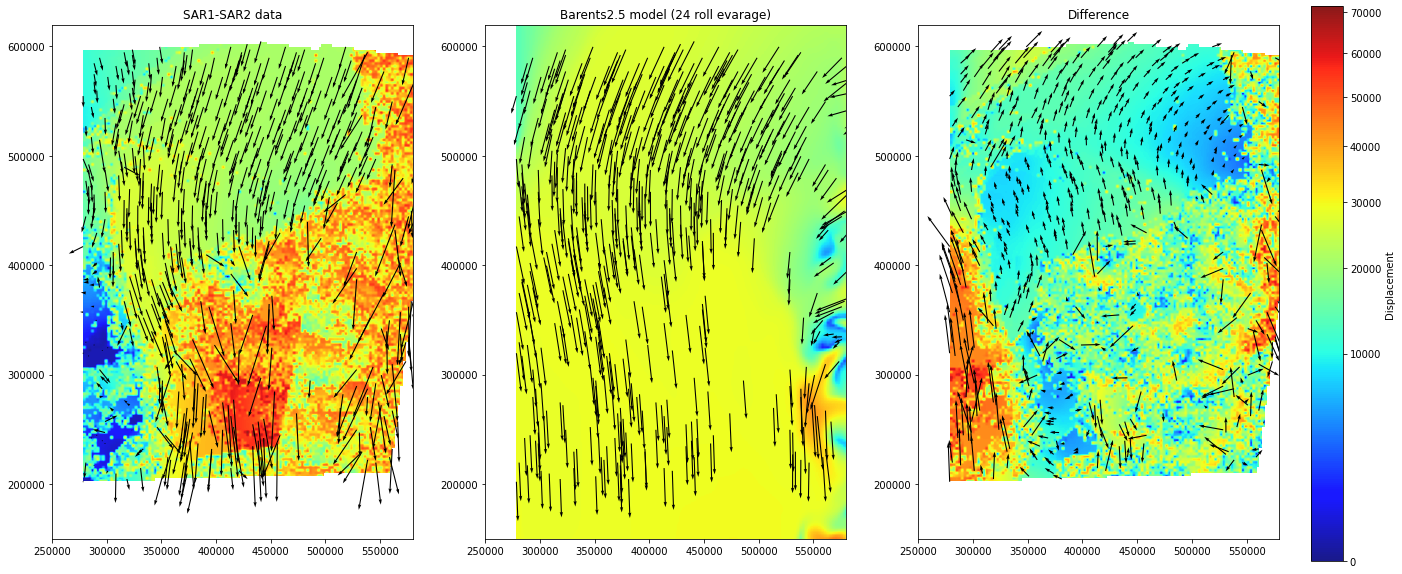

In [56]:
#Integrated drift filtered with gpi
from matplotlib.colors import PowerNorm
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))

disp_dif_x = upm - cum_dx_b_subset
disp_dif_y = vpm - cum_dy_b_subset
disp_dif = np.sqrt(( disp_dif_x**2+ disp_dif_y**2))

masked_disp_dif = np.full_like(disp_dif, np.nan)
masked_disp_dif[gpi_1416_02] = disp_dif[gpi_1416_02]

step = 20

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
quiver1 = ax1.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], upm[gpi_1416_02][::step], vpm[gpi_1416_02][::step], 
                    angles='xy', scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image1 = ax1.imshow(disp_alg, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax1.set_xlim([0.25e6, 0.58e6]) 
ax1.set_ylim([0.15e6, 0.62e6])

ax1.set_aspect('equal')

quiver2 = ax2.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], cum_dx_b_subset[gpi_1416_02][::step],cum_dy_b_subset[gpi_1416_02][::step],
                     angles='xy',scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image2 = ax2.imshow(disp_model_b, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax2.set_xlim([0.25e6, 0.58e6]) 
ax2.set_ylim([0.15e6, 0.62e6])
  
ax2.set_aspect('equal')

# Choose one of three ways to show difference:
# 0) Difference vectors
#quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
#                        np.hypot(disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step]), angles='xy', scale_units='xy', scale=0.8, cmap='jet', clim=[0, 40000])
# 1) Difference vectors without gradient (to combine with the raster)
quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
                        angles='xy', scale_units='xy', scale=1, cmap='Greys', clim=[0, 40000], width=0.003)
# 2) Difference raster masked with gpi
#ax3.imshow(masked_disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=1)
# 3) Total difference raster
image3 = ax3.imshow(disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)


ax3.set_xlim([0.25e6, 0.58e6]) 
ax3.set_ylim([0.15e6, 0.62e6])

ax3.set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(image1, cax=cbar_ax)
cbar.set_label('Displacement')

ax1.set_title("SAR1-SAR2 data")
ax2.set_title("Barents2.5 model (24 roll evarage)")
ax3.set_title("Difference")

plt.show()

In [50]:
# Masking rasters
# 1. Create an empty array filled with NaNs
masked_disp_alg = np.full_like(disp_alg, np.nan)
masked_disp_model_b = np.full_like(disp_model_b, np.nan)
masked_disp_dif = np.full_like(disp_dif, np.nan)
# 2. Place the masked data into this array
masked_disp_alg[gpi_1416_02] = disp_alg[gpi_1416_02]
masked_disp_model_b[gpi_1416_02] = disp_model_b[gpi_1416_02]
masked_disp_dif[gpi_1416_02] = disp_dif[gpi_1416_02]

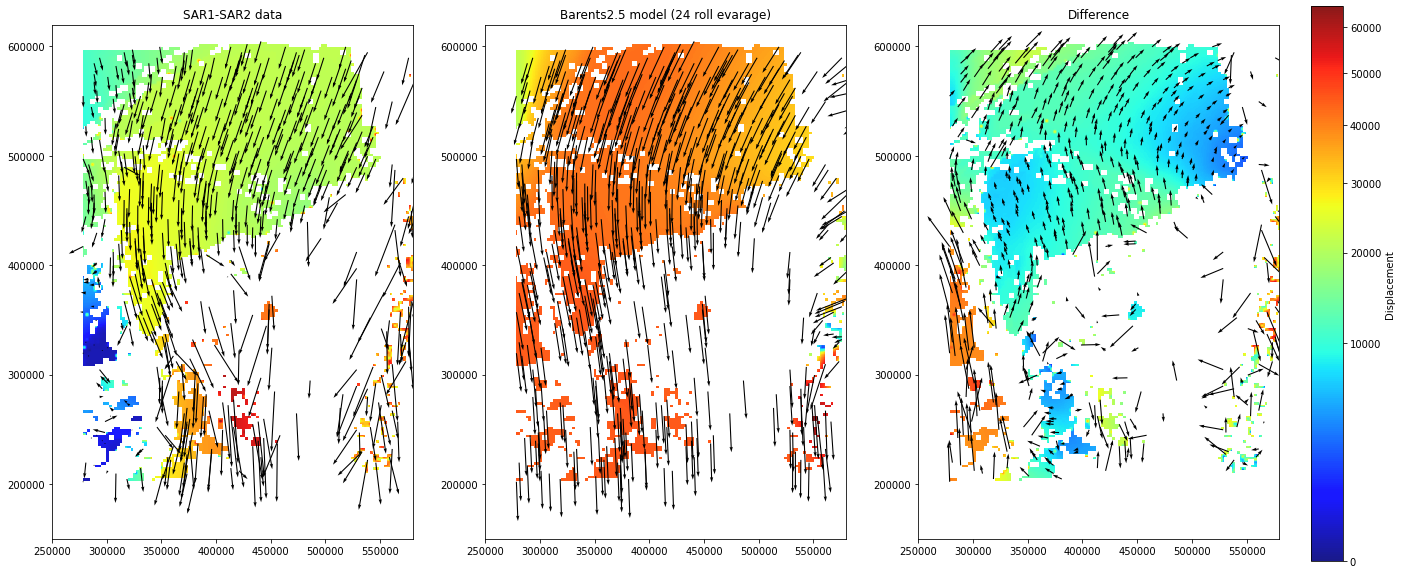

In [51]:
#Integrated drift filtered with gpi
from matplotlib.colors import PowerNorm
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))

disp_dif_x = upm - cum_dx_b_subset
disp_dif_y = vpm - cum_dy_b_subset
disp_dif = np.sqrt(( disp_dif_x**2+ disp_dif_y**2))

masked_disp_dif = np.full_like(disp_dif, np.nan)
masked_disp_dif[gpi_1416_02] = disp_dif[gpi_1416_02]

step = 20

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
quiver1 = ax1.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], upm[gpi_1416_02][::step], vpm[gpi_1416_02][::step], 
                    angles='xy', scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image1 = ax1.imshow(masked_disp_alg, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax1.set_xlim([0.25e6, 0.58e6]) 
ax1.set_ylim([0.15e6, 0.62e6])

ax1.set_aspect('equal')

quiver2 = ax2.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], cum_dx_b_subset[gpi_1416_02][::step],cum_dy_b_subset[gpi_1416_02][::step],
                     angles='xy',scale_units='xy', scale=1,cmap='Greys', clim=[0, 40000], width=0.003) 
image2 = ax2.imshow(masked_disp_model_b, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)

ax2.set_xlim([0.25e6, 0.58e6]) 
ax2.set_ylim([0.15e6, 0.62e6])
  
ax2.set_aspect('equal')

# Choose one of three ways to show difference:
# 0) Difference vectors
#quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
#                        np.hypot(disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step]), angles='xy', scale_units='xy', scale=0.8, cmap='jet', clim=[0, 40000])
# 1) Difference vectors without gradient (to combine with the raster)
quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
                        angles='xy', scale_units='xy', scale=1, cmap='Greys', clim=[0, 40000], width=0.003)
# 2) Difference raster masked with gpi
#ax3.imshow(masked_disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=1)
# 3) Total difference raster
image3 = ax3.imshow(masked_disp_dif, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)


ax3.set_xlim([0.25e6, 0.58e6]) 
ax3.set_ylim([0.15e6, 0.62e6])

ax3.set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(image1, cax=cbar_ax)
cbar.set_label('Displacement')

ax1.set_title("SAR1-SAR2 data")
ax2.set_title("Barents2.5 model (24 roll evarage)")
ax3.set_title("Difference")

plt.show()

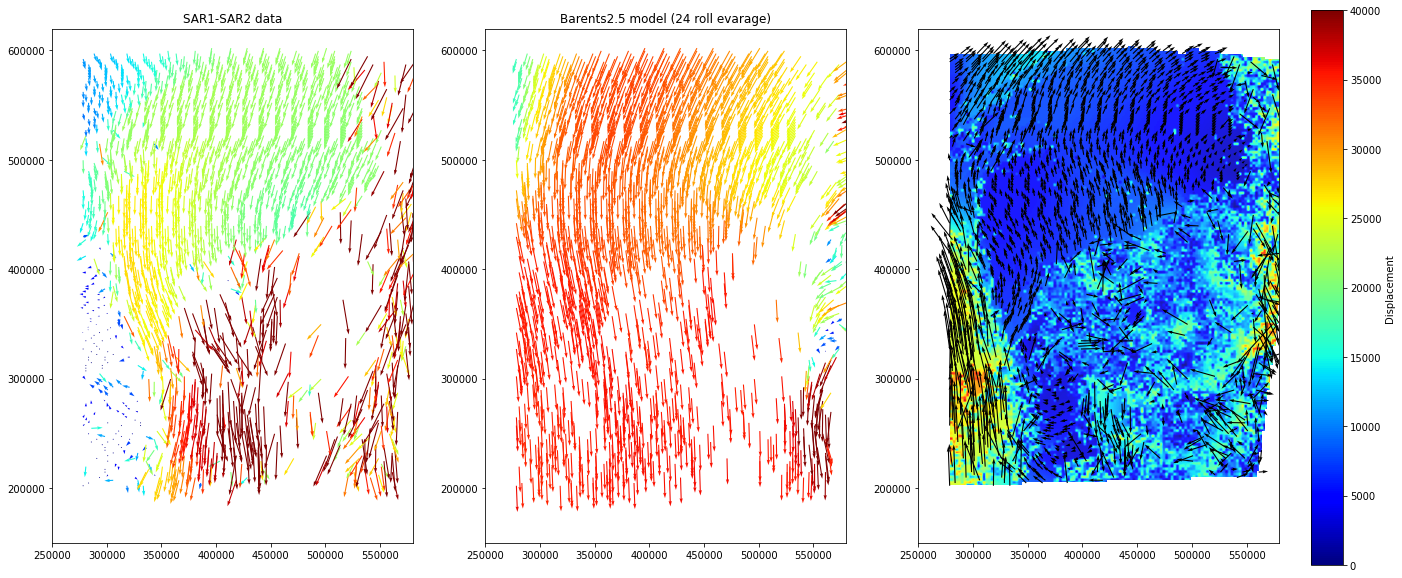

In [44]:
#Integrated drift filtered with gpi
from matplotlib.colors import PowerNorm
disp_dif_x = upm - cum_dx_b_subset
disp_dif_y = vpm - cum_dy_b_subset
disp_dif = np.sqrt(( disp_dif_x**2+ disp_dif_y**2)) 
masked_disp_dif = np.full_like(disp_dif, np.nan)
masked_disp_dif[gpi_1416_02] = disp_dif[gpi_1416_02]

step = 6

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(22,11))
quiver1 = ax1.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], upm[gpi_1416_02][::step], vpm[gpi_1416_02][::step], 
                        np.hypot(upm[gpi_1416_02][::step], vpm[gpi_1416_02][::step]), angles='xy', scale_units='xy', scale=1.5, 
                         cmap='jet', clim=[0, 40000], width=0.003)
ax1.set_xlim([0.25e6, 0.58e6]) 
ax1.set_ylim([0.15e6, 0.62e6])

ax1.set_aspect('equal')

quiver2 = ax2.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], cum_dx_b_subset[gpi_1416_02][::step],cum_dy_b_subset[gpi_1416_02][::step],
                     np.hypot(cum_dx_b_subset[gpi_1416_02][::step], cum_dy_b_subset[gpi_1416_02][::step]), angles='xy',
                     scale_units='xy', scale=1.5, cmap='jet',  clim=[0, 40000], width=0.003)

ax2.set_xlim([0.25e6, 0.58e6]) 
ax2.set_ylim([0.15e6, 0.62e6])
  
ax2.set_aspect('equal')

# Choose one of three ways to show difference:
# 0) Difference vectors
#quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
#                        np.hypot(disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step]), angles='xy', scale_units='xy', scale=0.8, cmap='jet', clim=[0, 40000])
# 1) Difference vectors without gradient (to combine with the raster)
quiver = ax3.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], disp_dif_x[gpi_1416_02][::step], disp_dif_y[gpi_1416_02][::step], 
                        angles='xy', scale_units='xy', scale=1, cmap='Greys', clim=[0, 40000], width=0.003)
# 2) Difference raster masked with gpi
#ax3.imshow(masked_disp_dif, cmap='jet',  origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=1)
# 3) Total difference raster
ax3.imshow(disp_dif, cmap='jet',  origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)


ax3.set_xlim([0.25e6, 0.58e6]) 
ax3.set_ylim([0.15e6, 0.62e6])

ax3.set_aspect('equal')

# Create a colorbar axis
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(quiver1, cax=cbar_ax)
cbar.set_label('Displacement')

ax1.set_title("SAR1-SAR2 data")
ax2.set_title("Barents2.5 model (24 roll evarage)")

plt.show()

In [24]:
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))
disp_model_b = disp_model_b[gpi_1416_02].flatten()
disp_alg = disp_alg[gpi_1416_02].flatten()
disp_model_b.shape, disp_alg.shape
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))
disp_model_b = disp_model_b.flatten()
disp_alg = disp_alg.flatten()
disp_model_b.shape, disp_alg.shape

((61977,), (61977,))

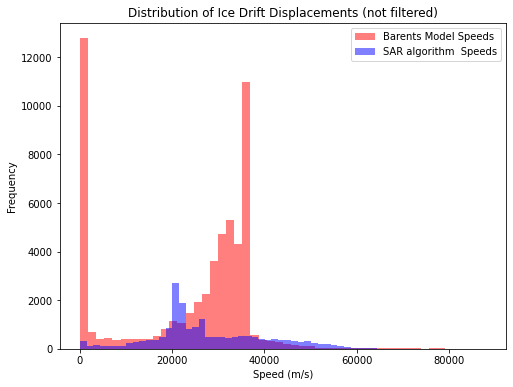

'\n# Print statistics for reference speeds\npercentile_95_ref = np.percentile(speed_model_b, 95)\nmean_speed_ref = np.nanmean(speed_model_b)\nmin_speed_ref = np.nanmin(speed_model_b)\nmax_speed_ref = np.nanmax(speed_model_b)\n\nprint(f"Reference Speeds:")\nprint(f"Mean speed: {mean_speed_ref:.4f} m/s")\nprint(f"Min speed: {min_speed_ref:.4f} m/s")\nprint(f"Max speed: {max_speed_ref:.4f} m/s")\nprint(f"95th percentile speed: {percentile_95_ref:.4f} m/s")\n\n# Print statistics for model speeds\npercentile_95_model = np.percentile(speed_model_b, 95)\nmean_speed_model = np.nanmean(speed_model_b)\nmin_speed_model = np.nanmin(speed_model_b)\nmax_speed_model = np.nanmax(speed_model_b)\n\nprint("\nModel Speeds:")\nprint(f"Mean speed: {mean_speed_model:.4f} m/s")\nprint(f"Min speed: {min_speed_model:.4f} m/s")\nprint(f"Max speed: {max_speed_model:.4f} m/s")\nprint(f"95th percentile speed: {percentile_95_model:.4f} m/s")\n'

In [71]:
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))

disp_model_b = disp_model_b.flatten()
disp_alg = disp_alg.flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (not filtered)')
plt.legend()
plt.show()



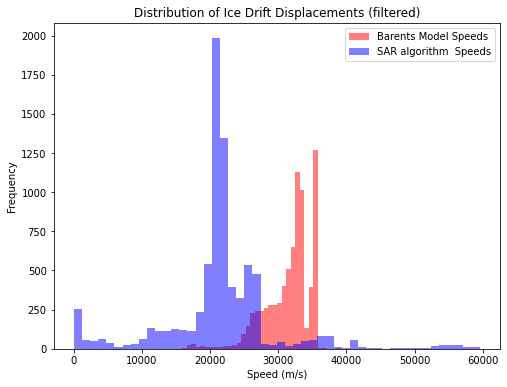

Reference Speeds:
Mean speed: 21492.1088 m/s
Min speed: 0.0000 m/s
Max speed: 59552.9003 m/s
95th percentile speed: 36040.2014 m/s

Model Speeds:
Mean speed: 31543.5854 m/s
Min speed: 15262.6694 m/s
Max speed: 48354.7660 m/s
95th percentile speed: 35562.3022 m/s


In [72]:
disp_model_b = np.sqrt(( cum_dx_b_subset**2+ cum_dy_b_subset**2)) 
disp_alg = np.sqrt((upm**2+vpm**2))

disp_model_b = disp_model_b[gpi_1416_02].flatten()
disp_alg = disp_alg[gpi_1416_02].flatten()


plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(disp_model_b, bins=50, color='red', alpha=0.5, label= 'Barents Model Speeds')

# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (filtered)')
plt.legend()
plt.show()


# Print statistics for reference speeds
percentile_95_ref = np.percentile(disp_alg, 95)
mean_speed_ref = np.nanmean(disp_alg)
min_speed_ref = np.nanmin(disp_alg)
max_speed_ref = np.nanmax(disp_alg)

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(disp_model_b, 95)
mean_speed_model = np.nanmean(disp_model_b)
min_speed_model = np.nanmin(disp_model_b)
max_speed_model = np.nanmax(disp_model_b)

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


In [97]:
def angle_between_vector_fields(A, B, epsilon=1e-10):
    # Compute the dot product for each vector pair
    dot_product = np.sum(A * B, axis=0)
    
    # Compute the magnitudes of each vector in the fields
    magnitude_A = np.linalg.norm(A, axis=0)
    magnitude_B = np.linalg.norm(B, axis=0)
    
    # Add a small epsilon to avoid division by zero
    magnitude_A += epsilon
    magnitude_B += epsilon
    
    # Compute cosine similarity for each vector pair
    cosine_similarity = dot_product / (magnitude_A * magnitude_B)
    
    # Compute the angles in degrees for each vector pair
    angles = np.degrees(np.arccos(np.clip(cosine_similarity, -1.0, 1.0)))
    
    return angles, cosine_similarity


angles_field, cosine_similarity = angle_between_vector_fields(vector_model_b, vector_alg)

# For example, print the angle between the vectors at location (50,50)
print(angles_field[100,100])


44.54087275299813


In [228]:
# 1. Create an empty array filled with NaNs
masked_angles_field = np.full_like(angles_field, np.nan)

# 2. Place the masked data into this array
masked_angles_field[gpi_1416_02] = angles_field[gpi_1416_02]



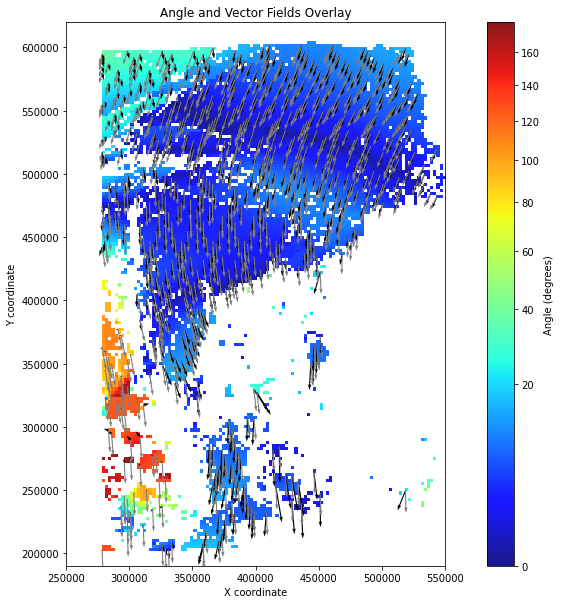

In [294]:
from matplotlib.colors import PowerNorm
plt.figure(figsize=(15, 10))
plt.imshow(masked_angles_field, cmap='jet', norm=PowerNorm(gamma=0.5), origin='lower', extent=[X_subset.min(), X_subset.max(), Y_subset.min(), Y_subset.max()], alpha=0.9)
plt.colorbar(label='Angle (degrees)')

plt.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], 
           upm[gpi_1416_02][::step], vpm[gpi_1416_02][::step], 
           angles='xy', scale_units='xy', scale=2, color='black',width=0.003)
plt.quiver(X_subset[gpi_1416_02][::step], Y_subset[gpi_1416_02][::step], 
           cum_dx_b_subset[gpi_1416_02][::step], cum_dy_b_subset[gpi_1416_02][::step], 
           angles='xy', scale_units='xy', scale=2, color='grey',width=0.003)


# Setting plot limits and labels
plt.xlim([250000, 550000]) 
plt.ylim([190000, 620000])
#plt.legend()
plt.title('Angle and Vector Fields Overlay')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()
